In [1]:
import torchfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, sampler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [50]:
def evaluate_loss(model, data, labels, loss_fn):
    """
    evaluate the loss
    """
    predicted = model(data)
    errors = loss_fn(predicted, labels)
    return float(errors)


def plot_loss(train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.show()
  
def save_plot(name, train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.savefig(name)

def train(model, epochs, loader, loss_fn, optimizer, scheduler, X_val, Y_val, print_every=10):
    train_loss = []
    val_loss = []
    train_loss.append(evaluate_loss(model, loader.dataset.tensors[0], loader.dataset.tensors[1], loss_fn))
    val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
    for e in range(1,epochs + 1):
        batches_loss = []
        for t, (x, y) in enumerate(loader):
            scheduler.step()
            model.train()
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = model(x)
            # Calculate Loss
            loss = loss_fn(y_pred, y)
            # optimization
            optimizer.zero_grad()
            # backward propagation
            loss.backward()
            # Updating parameters
            optimizer.step()
            batches_loss.append(loss.item())
        if e % print_every == 0:
            print(f'ephoc {e}, loss = {np.mean(np.array(batches_loss)):.4f}  val_loss = {evaluate_loss(model, X_val, Y_val, loss_fn):.4f}')
            
        train_loss.append(np.mean(np.array(batches_loss)))
        val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
        
    return train_loss, val_loss


import torch.nn as nn
class View(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [5]:
C = 3
L = 12
W = 12
output_dim = 2

In [6]:
data_dict = torchfile.load('./EX2_data/aflw/aflw_12.t7')

In [7]:
data = []
for key in data_dict:
    data.append(data_dict[key])
data = np.stack(data)

In [8]:
data.shape

(24385, 3, 12, 12)

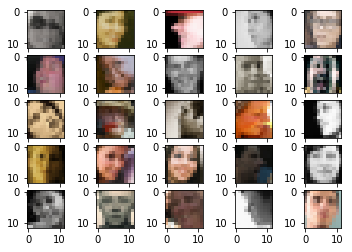

In [9]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, data.shape[0], 25)):
    ax.imshow(np.moveaxis(data[idx], 0, 2))

In [10]:
person_images_df = pd.read_csv('./EX2_data/VOCdevkit/VOC2007/ImageSets/Main/person_trainval.txt', sep = '\s+', header=None,  dtype={0: str})

In [11]:
person_images_df = person_images_df[person_images_df[1] == -1]

In [12]:
person_images_df.shape

(2916, 2)

In [35]:
num_crop = 10
false_imgs = []
for img_num in person_images_df[0]:
    img = imread('./EX2_data/VOCdevkit/VOC2007/JPEGImages/%s.jpg' %img_num)
    for i, j in zip(np.random.randint(0, img.shape[0] - L, num_crop),
                    np.random.randint(0, img.shape[1] - W, num_crop)):
        crop_img = img[i:i+L, j:j+W, :].copy()
        false_imgs.append(crop_img)
false_imgs = np.moveaxis(np.stack(false_imgs), 3, 1) / 255

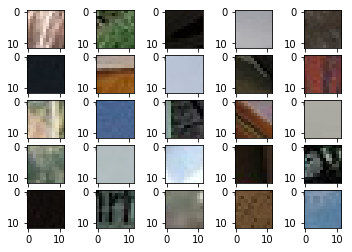

In [51]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, false_imgs.shape[0], 25)):
    ax.imshow(np.moveaxis(false_imgs[idx], 0, 2))

In [52]:
X = np.concatenate((data, false_imgs))
Y = np.concatenate((np.ones(data.shape[0]), np.zeros(false_imgs.shape[0])))
X.shape, Y.shape

((53545, 3, 12, 12), (53545,))

In [53]:
conv_12_dim = 16
conv_12_size = 3
conv_12_stride = 1
conv_12_pad = 1
max_pool_size = 3
max_pool_stride = 2
max_pool_pad=1
fc_12_size = 16

val_precenteg = 0.15
BATCH_SIZE = 128
print_every = 10

In [54]:
tw_net = nn.Sequential(nn.Conv2d(C, conv_12_dim, conv_12_size, padding=conv_12_pad),
                           nn.MaxPool2d(kernel_size=max_pool_size, stride=max_pool_stride, padding=max_pool_pad),
                           nn.ReLU(),
                           View(),
                           nn.Linear((L // 2) ** 2 * conv_12_dim, fc_12_size),
                           nn.ReLU(),
                           nn.Linear(fc_12_size, output_dim)).to(device=device)

In [55]:
mask = np.arange(0, X.shape[0])
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * val_precenteg)]
train_mask = mask[int(X.shape[0] * val_precenteg):]

X_val = torch.FloatTensor(X[val_mask]).to(device=device)
X_train = torch.FloatTensor(X[train_mask]).to(device=device)
Y_val = torch.LongTensor(Y[val_mask]).to(device=device)
Y_train = torch.LongTensor(Y[train_mask]).to(device=device)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [69]:
conv_train_loss_lst, conv_val_loss_lst = [], []

loss_fn = F.cross_entropy

optimizer = optim.Adam(tw_net.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1.0)

In [68]:
loss = train(tw_net, 5, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)

<class 'tuple'>
<class 'torch.Tensor'>


TypeError: softmax(): argument 'dim' (position 1) must be int, not Tensor

In [66]:
loss

([0.6889282464981079,
  0.6891653159361207,
  0.6891636830032541,
  0.6891712238279621,
  0.6891782744212097,
  0.6891999227947063],
 [0.6892591118812561,
  0.689296543598175,
  0.689226508140564,
  0.689263641834259,
  0.6892579197883606,
  0.6892540454864502])